# Explainability and robustness checks

In [1]:
# Standard library
import os
import re
import warnings
from pathlib import Path

# Core libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Forecasting/ML
from prophet import Prophet
import shap

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Statsmodels
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX

# XGBoost
from xgboost import XGBRegressor

# Warning filters
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Time series model interpretability

Interpretability analyses were conducted for all baseline time series models:

* For ARIMA and SARIMA models with exogenous regressors:

  * Significant autoregressive, moving average, and seasonal terms were interpreted, with emphasis on the role of seasonal lags.
  * The statistical significance and directional effects of exogenous regressors (e.g., temperature and holiday indicators) were assessed.

* For ETS models with exogenous regressors:

  * Model decompositions into level, trend, and seasonal components were examined and related to the conceptual temporal structure of demand.

* For Prophet models with exogenous regressors:

  * Trend and seasonal components were visualized to characterize long-term and periodic patterns.
  * The estimated effects of external regressors, such as holidays and temperature, were examined through component plots.

SARIMAX(1,0,1)×(0,1,1)(_7) coefficient estimates (system-level daily)

| Component   | Variable           | Coefficient | Interpretation                                 |
| ----------- | ------------------ | ----------: | ---------------------------------------------- |
| Weather     | Temperature (°F)   |      +818.6 | Higher temperatures increase system demand     |
| Weather     | Precipitation (in) |     −20,900 | Rain strongly suppresses demand                |
| Calendar    | Holiday            |     −11,265 | Holidays reduce daily trips                    |
| Calendar    | Weekend            |         ≈ 0 | No additional effect beyond weekly seasonality |
| Regime      | Pre-COVID          |        n.s. | No stable additive shift                       |
| Regime      | COVID              |        n.s. | No stable additive shift                       |
| Regime      | Recovery           |        n.s. | No stable additive shift                       |
| AR          | AR(1)              |      +0.957 | Strong short-run persistence                   |
| MA          | MA(1)              |      −0.675 | Short-run error correction                     |
| Seasonal MA | MA(7)              |      −0.904 | Dominant weekly stochastic dependence          |

*Notes:* n.s. denotes not statistically significant at the 5% level.

In [2]:
DATA_ROOT = "/Users/zoltanjelovich/Documents/ISEG/MFW/data"

SYSTEM_DAILY_PATH = f"{DATA_ROOT}/features/system/X_daily_system.parquet"

df = pd.read_parquet(SYSTEM_DAILY_PATH).copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

DATE_COL = "date"
TARGET_COL = "trips"

EXOG_COLS = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

In [3]:
# Define the “train+val” window

TRAINVAL_END = pd.Timestamp("2022-12-31")

trainval = df[df[DATE_COL] <= TRAINVAL_END].copy()
trainval = trainval.dropna(subset=[TARGET_COL] + EXOG_COLS)

15:46:48 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing


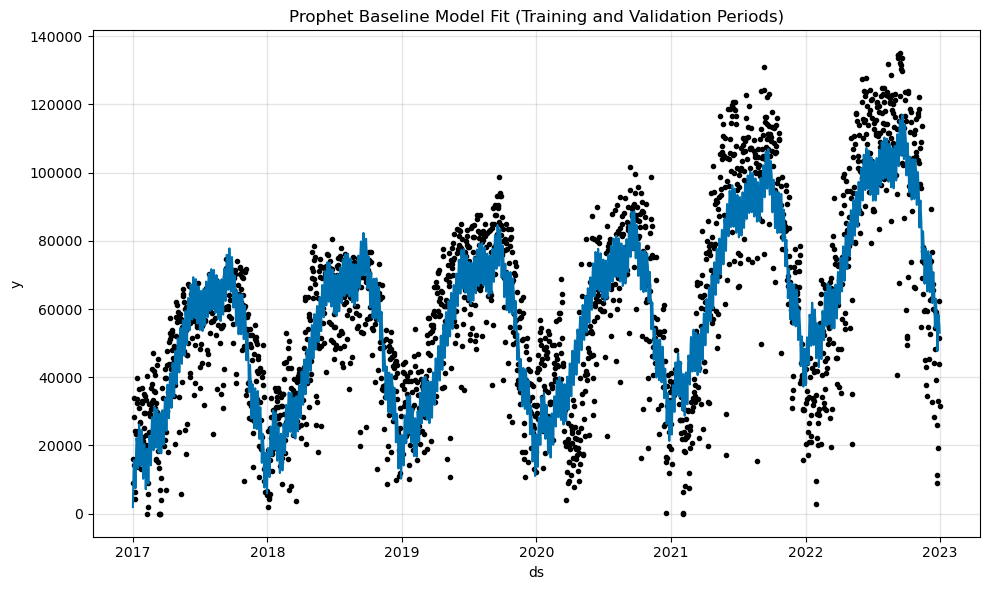

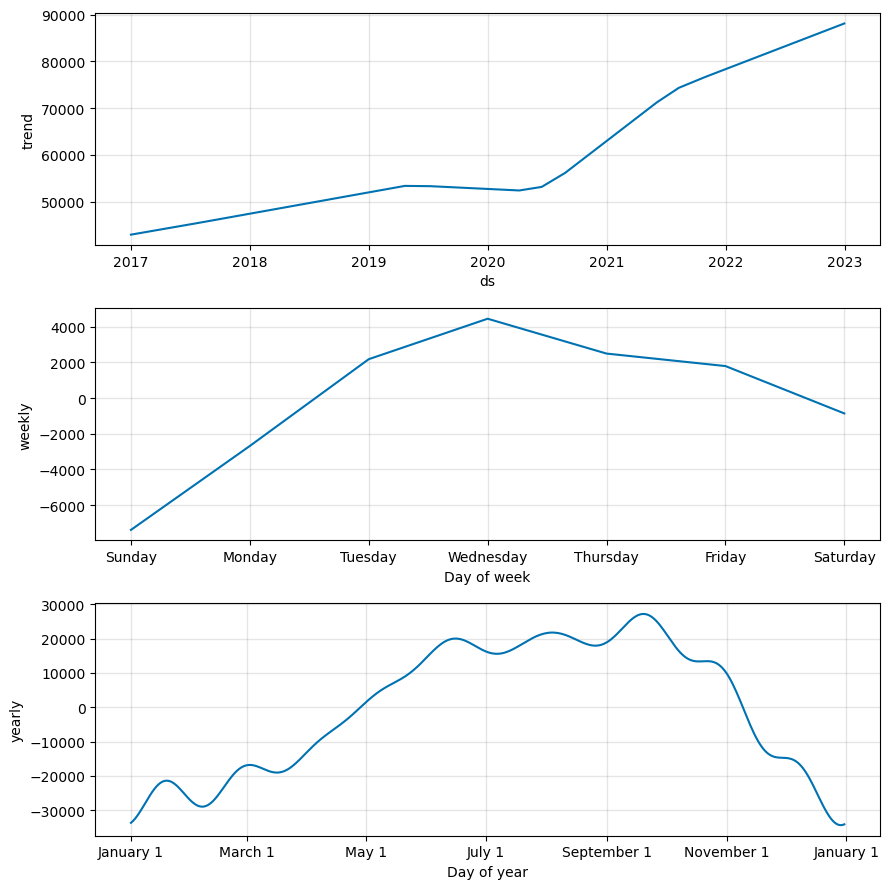

In [4]:
# Prophet baseline (no exog) + component plots

trainval_df = (
    trainval[[DATE_COL, TARGET_COL]]
    .rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
    .sort_values("ds")
)

m_base = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    uncertainty_samples=0,
)

m_base.fit(trainval_df)

fc_base = m_base.predict(trainval_df[["ds"]])

m_base.plot(fc_base)
plt.title("Prophet Baseline Model Fit (Training and Validation Periods)")
plt.tight_layout()
plt.show()

m_base.plot_components(fc_base)
plt.tight_layout()
plt.show()

15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing


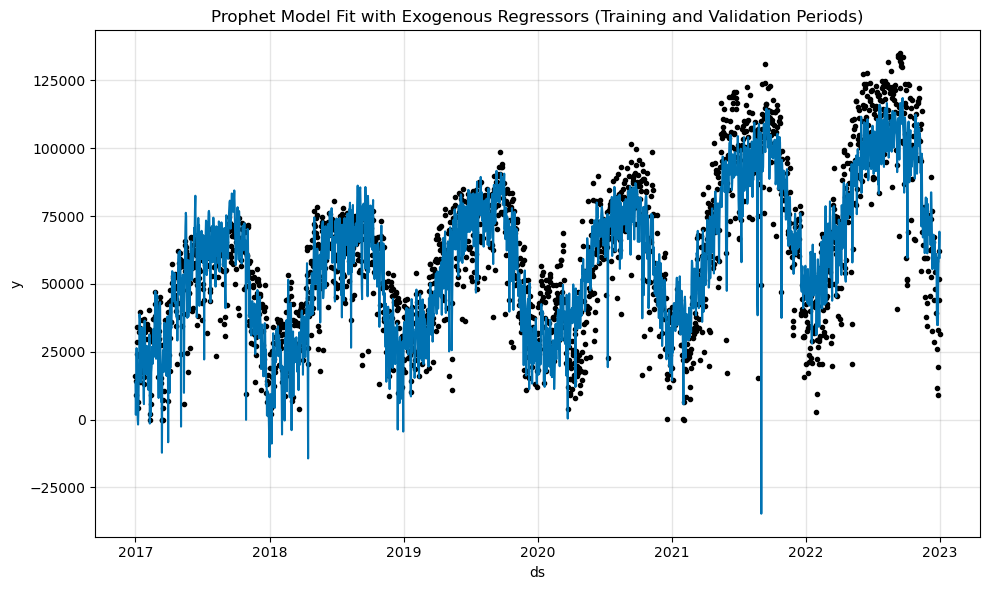

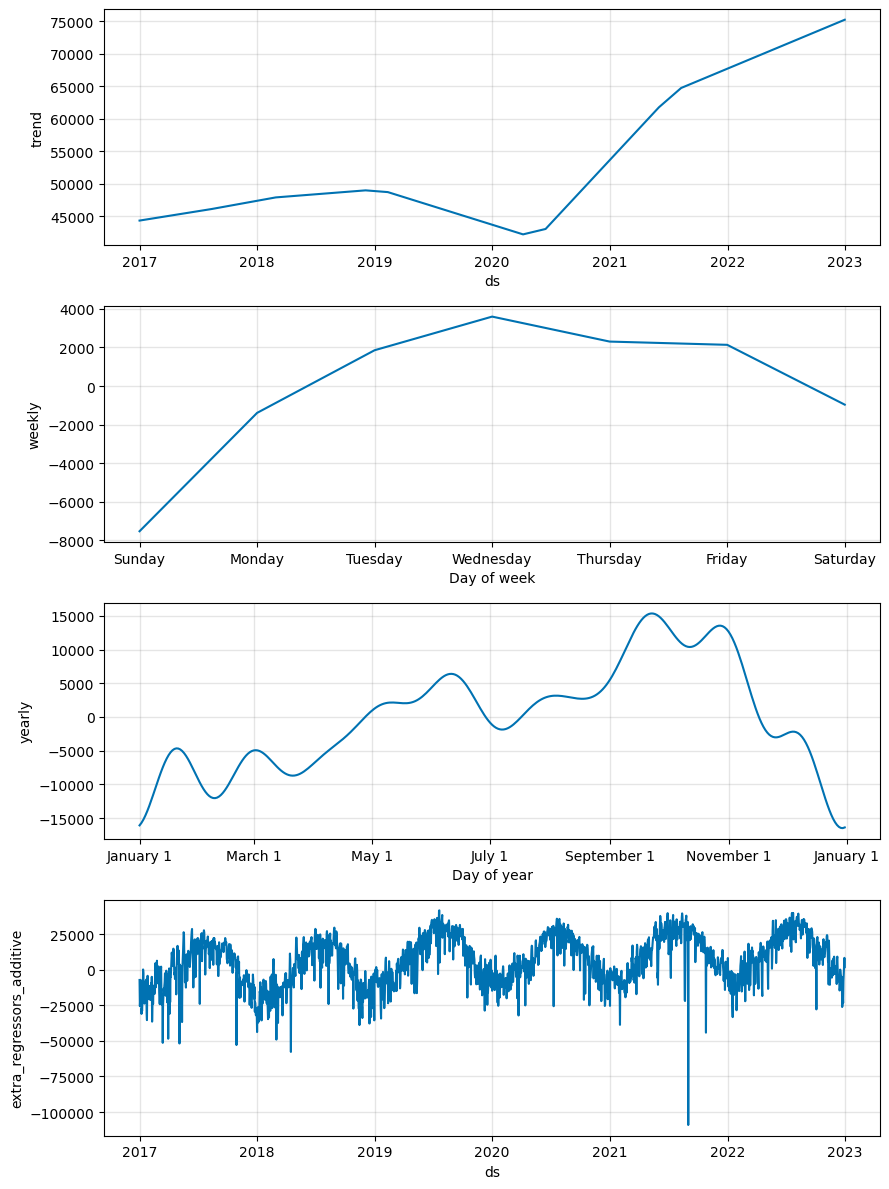

In [5]:
# Prophet + exog + component plots

trainval_exog = (
    trainval[[DATE_COL, TARGET_COL] + EXOG_COLS]
    .rename(columns={DATE_COL: "ds", TARGET_COL: "y"})
    .sort_values("ds")
)

m_exog = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode="additive",
    uncertainty_samples=0,
)

for c in EXOG_COLS:
    m_exog.add_regressor(c)

m_exog.fit(trainval_exog[["ds", "y"] + EXOG_COLS])

fc_exog = m_exog.predict(trainval_exog[["ds"] + EXOG_COLS])

m_exog.plot(fc_exog)
plt.title("Prophet Model Fit with Exogenous Regressors (Training and Validation Periods)")
plt.tight_layout()
plt.show()

m_exog.plot_components(fc_exog)
plt.tight_layout()
plt.show()

,regressor,approx_trips_per_unit
0,is_holiday,-3312.889712
1,precip_inches,-3185.287057
2,regime_pre_covid,-2490.146819
3,regime_recovery,-477.885772
4,temp_avg_f,-86.326159
5,regime_covid,1797.699105


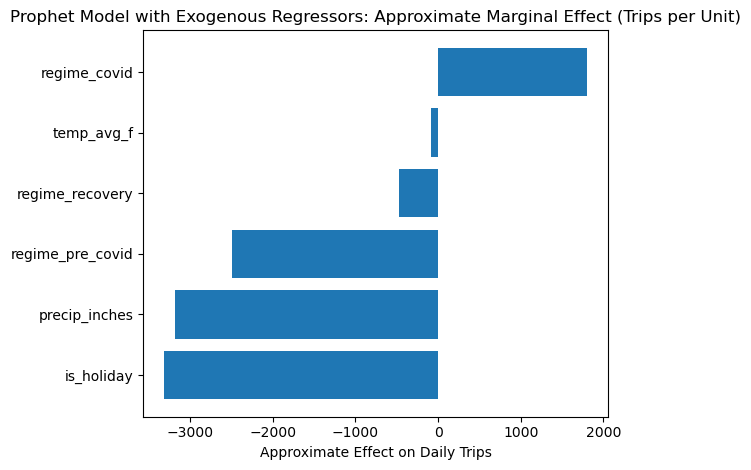

In [6]:
# Regressor effect-size table + bar plot

# Extract Prophet regressor betas (standardized)
beta = m_exog.params["beta"][0]
regressor_names = list(m_exog.extra_regressors.keys())

coef_raw = pd.DataFrame({
    "regressor": regressor_names,
    "beta_raw": beta[:len(regressor_names)],
})

# Approximate effect in trips per one unit of regressor:
# effect_per_unit ≈ beta_raw * (std_y / std_x)
y_std = trainval_exog["y"].std()

effects = []
for r in regressor_names:
    x_std = trainval_exog[r].std()
    effects.append((y_std / x_std) if x_std != 0 else np.nan)

coef_raw["approx_trips_per_unit"] = coef_raw["beta_raw"] * np.array(effects)

# More dissertation-friendly view
coef_view = (
    coef_raw[["regressor", "approx_trips_per_unit"]]
    .sort_values("approx_trips_per_unit")
    .reset_index(drop=True)
)

display(coef_view)

# Bar plot for quick interpretability
plt.figure()
plt.barh(coef_view["regressor"], coef_view["approx_trips_per_unit"])
plt.title("Prophet Model with Exogenous Regressors: Approximate Marginal Effect (Trips per Unit)")
plt.xlabel("Approximate Effect on Daily Trips")
plt.tight_layout()
plt.show()

## SHAP analysis for Random Forest and XGBoost

SHAP analyses were conducted for the best-performing tree-based models at the system and station levels:

* Global SHAP values were computed:

  * Features were ranked by overall importance (e.g., temperature, hour of day, day of week, precipitation, income).
  * Feature contributions were interpreted in relation to the conceptual framework:

    * Weather variables as external forcing.
    * Calendar variables as temporal structure.
    * Demographic and built-environment variables as contextual factors.

* Local SHAP analyses were performed for selected days and stations:

  * Representative cases were examined, such as peak commuting days and weekend days.
  * The interactions between weather and calendar features were interpreted to explain upward or downward shifts in model predictions.

### Global SHAP for system-level hourly RF

In [7]:
BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SYS_H = BASE / "modeling/system/hourly_ml"

def load_split(split: str) -> pd.DataFrame:
    return pd.read_parquet(SYS_H / f"{split}.parquet")

train_df = load_split("train")
val_df   = load_split("val")
test_df  = load_split("test")

TARGET = "y"
DROP_COLS = ["pred_time"]

X_train = train_df.drop(columns=[TARGET] + DROP_COLS)
y_train = train_df[TARGET]

X_val = val_df.drop(columns=[TARGET] + DROP_COLS)
y_val = val_df[TARGET]

X_test = test_df.drop(columns=[TARGET] + DROP_COLS)
y_test = test_df[TARGET]

print(X_train.shape, X_val.shape, X_test.shape)

(43823, 54) (8760, 54) (17544, 54)


In [8]:
cat_cols = ["day_type", "pandemic_regime"]

def drop_datetime_cols(X: pd.DataFrame) -> pd.DataFrame:
    dt_cols = list(X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
    if dt_cols:
        print("Dropping datetime columns:", dt_cols)
        return X.drop(columns=dt_cols)
    return X

X_train = drop_datetime_cols(X_train)
X_val   = drop_datetime_cols(X_val)
X_test  = drop_datetime_cols(X_test)

# Safety drop: unexpected object columns besides known categoricals
obj_cols = [c for c in X_train.columns if X_train[c].dtype == "object" and c not in cat_cols]
if obj_cols:
    print("Dropping unexpected object columns:", obj_cols)
    X_train = X_train.drop(columns=obj_cols)
    X_val   = X_val.drop(columns=obj_cols)
    X_test  = X_test.drop(columns=obj_cols)

num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

print("Final X shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Categoricals:", cat_cols)
print("Num cols:", len(num_cols))

Dropping datetime columns: ['date']
Dropping datetime columns: ['date']
Dropping datetime columns: ['date']
Final X shapes: (43823, 53) (8760, 53) (17544, 53)
Categoricals: ['day_type', 'pandemic_regime']
Num cols: 51


In [9]:
# Combine train + val
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

best_params_rf_sys_hourly = {
    "rf__n_estimators": 300,
    "rf__max_depth": 25,
    "rf__min_samples_leaf": 5,
}

rf_sys_hourly = Pipeline(
    steps=[
        ("prep", preprocess),
        ("rf", RandomForestRegressor(random_state=42, n_jobs=-1)),
    ]
)
rf_sys_hourly.set_params(**best_params_rf_sys_hourly)

rf_sys_hourly.fit(X_trainval, y_trainval)

pred = rf_sys_hourly.predict(X_test)

rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print("Recomputed test metrics (should match HTML closely):")
print("RMSE:", round(rmse, 2), "MAE:", round(mae, 2), "R2:", round(r2, 4))

Recomputed test metrics (should match HTML closely):
RMSE: 1181.86 MAE: 688.26 R2: 0.8996


In [10]:
rf_model = rf_sys_hourly.named_steps["rf"]
feat_names = rf_sys_hourly.named_steps["prep"].get_feature_names_out()

# Preprocess once
X_test_proc = rf_sys_hourly.named_steps["prep"].transform(X_test)

# Use a smaller, fixed sample for speed + reproducibility
rng = np.random.RandomState(42)
n_shap = 1000  # start here; we can increase to 2000 if it's fast
idx = rng.choice(X_test_proc.shape[0], size=min(n_shap, X_test_proc.shape[0]), replace=False)

X_shap = X_test_proc[idx]

# TreeExplainer is correct for RF, but set check_additivity=False for speed
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap, check_additivity=False)

print("SHAP computed on sample size:", X_shap.shape[0], "features:", X_shap.shape[1])

SHAP computed on sample size: 1000 features: 57


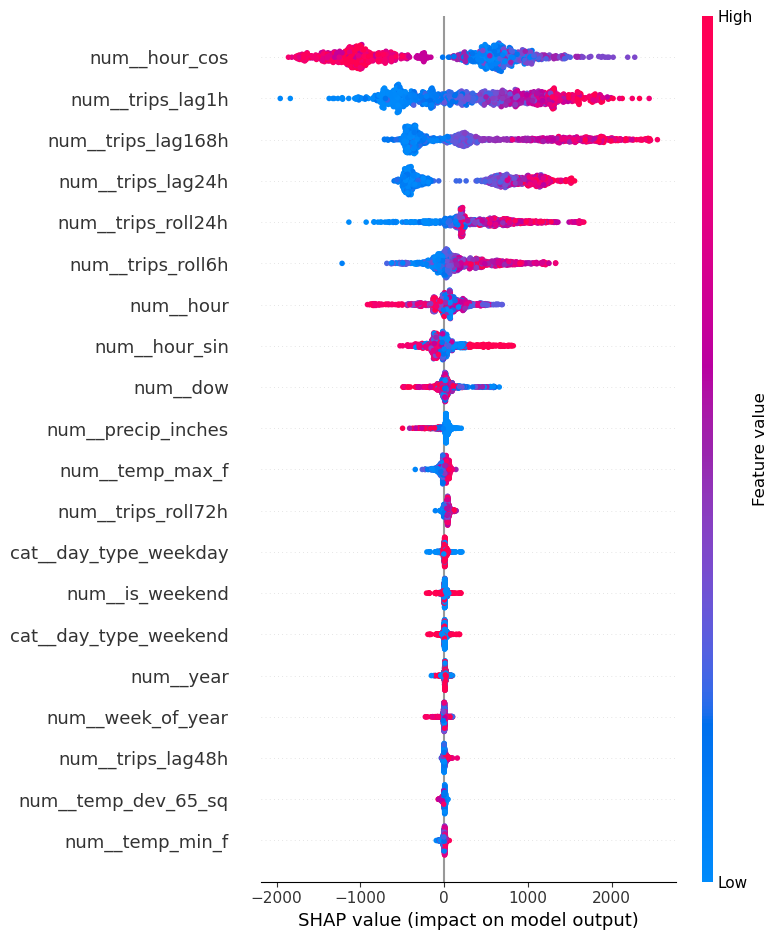

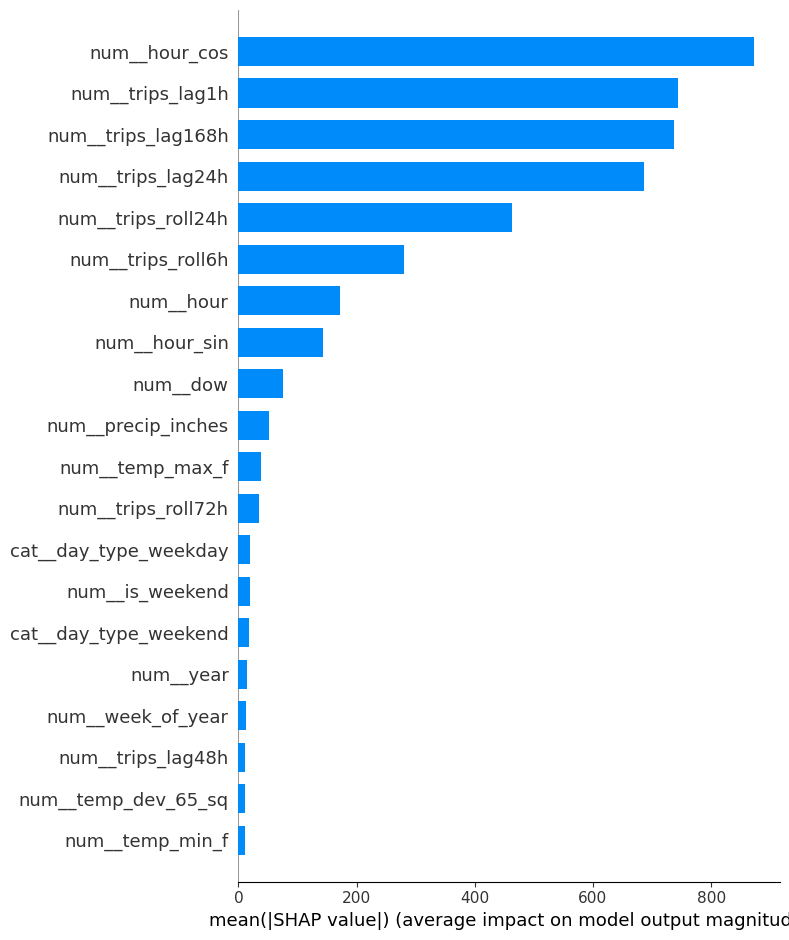

In [11]:
shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=False)
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_shap, feature_names=feat_names, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

In [12]:
mean_abs = np.abs(shap_values).mean(axis=0)
top = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

display(top.head(20))

,feature,mean_abs_shap
0,num__hour_cos,872.904238
1,num__trips_lag1h,744.130163
2,num__trips_lag168h,736.705353
3,num__trips_lag24h,686.865924
4,num__trips_roll24h,463.193048
5,num__trips_roll6h,280.742926
6,num__hour,172.162156
7,num__hour_sin,143.685945
8,num__dow,75.264979
9,num__precip_inches,51.942898


### Local SHAP for two defensible examples (system hourly RF)

In [13]:
# Keep the original test_df with pred_time for selection
test_df_full = test_df.copy()
test_df_full["pred_time"] = pd.to_datetime(test_df_full["pred_time"])

# Helper columns
test_df_full["hour"] = test_df_full["pred_time"].dt.hour
test_df_full["dow"]  = test_df_full["pred_time"].dt.dayofweek  # Mon=0 ... Sun=6

# Weekday commuting window: 7–10 and 16–19, weekdays only
commute_mask = (
    (test_df_full["dow"] <= 4) &
    (test_df_full["hour"].isin([7,8,9,16,17,18]))
)

commute_candidates = test_df_full.loc[commute_mask].copy()
# Pick the highest observed demand hour within commuting windows (clear "peak commute" example)
row_commute = commute_candidates.sort_values("y", ascending=False).iloc[0]

# Weekend typical demand: weekend only, mid-day window 11–15, choose a "typical" hour
weekend_mask = (
    (test_df_full["dow"] >= 5) &
    (test_df_full["hour"].between(11, 15))
)

weekend_candidates = test_df_full.loc[weekend_mask].copy()
# Choose a typical (median) demand hour to avoid selecting extremes
median_y = weekend_candidates["y"].median()
row_weekend = weekend_candidates.iloc[(weekend_candidates["y"] - median_y).abs().argsort().iloc[0]]

print("Selected weekday commute peak:")
print("  pred_time:", row_commute["pred_time"], "| y:", row_commute["y"], "| day_type:", row_commute.get("day_type", None))

print("\nSelected weekend typical hour:")
print("  pred_time:", row_weekend["pred_time"], "| y:", row_weekend["y"], "| day_type:", row_weekend.get("day_type", None))

Selected weekday commute peak:
  pred_time: 2024-10-22 17:00:00 | y: 19576 | day_type: weekday

Selected weekend typical hour:
  pred_time: 2023-05-07 11:00:00 | y: 7874 | day_type: weekend



Local SHAP Explanation: Weekday Commute Peak (System-Level Hourly Random Forest)
  prediction: 12979.468105853572 | base_value: 2489.5438596124222
  Top contributions (feature, SHAP):
   - num__trips_lag168h: +2347.84
   - num__trips_roll24h: +1634.69
   - num__trips_lag24h: +1493.66
   - num__trips_lag1h: +1295.29
   - num__trips_roll6h: +1165.70
   - num__hour_cos: +988.15
   - num__dow: +546.56
   - num__hour: +467.08
   - num__hour_sin: +245.35
   - num__precip_inches: +61.98
   - num__temp_max_f: +61.90
   - num__trips_roll72h: +41.58


/var/folders/lm/tx5m_rsx42d8dp9md2z_by1m0000gn/T/ipykernel_19083/265332672.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("  prediction:", float(pred), "| base_value:", float(base))


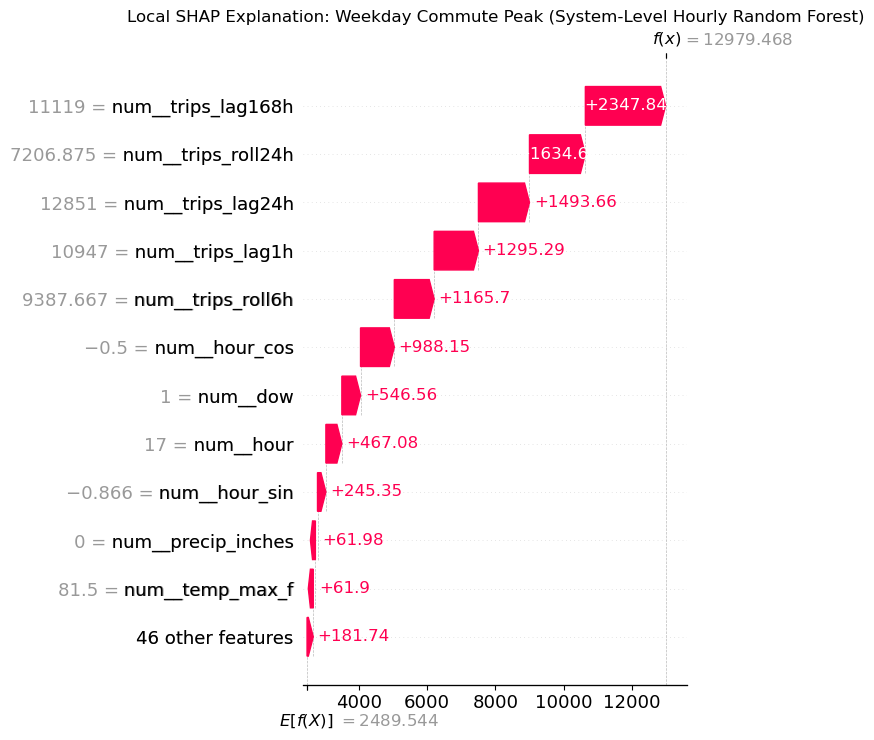


Local SHAP Explanation: Typical Weekend Hour (System-Level Hourly Random Forest)
  prediction: 6983.8190934554505 | base_value: 2489.5438596124222
  Top contributions (feature, SHAP):
   - num__trips_lag24h: +927.38
   - num__trips_roll24h: +886.62
   - num__hour_cos: +858.45
   - num__trips_lag1h: +476.83
   - num__dow: +212.43
   - cat__day_type_weekday: +191.05
   - num__is_weekend: +178.03
   - num__trips_lag168h: +169.28
   - num__trips_roll6h: +168.31
   - cat__day_type_weekend: +148.26
   - num__trips_roll72h: +86.94
   - num__hour_sin: -66.45


/var/folders/lm/tx5m_rsx42d8dp9md2z_by1m0000gn/T/ipykernel_19083/265332672.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("  prediction:", float(pred), "| base_value:", float(base))


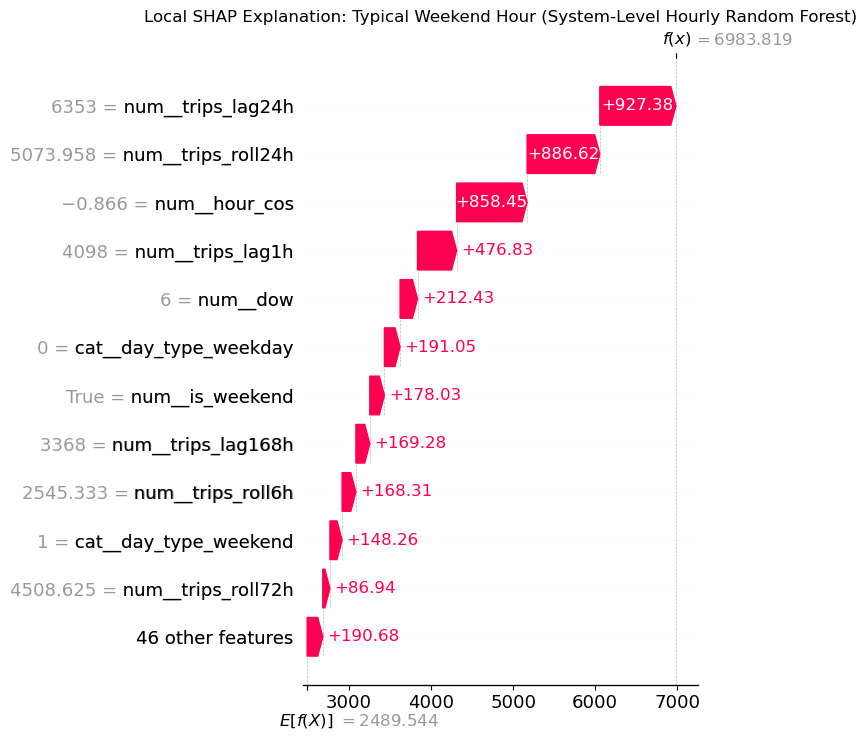

In [14]:
feat_names = rf_sys_hourly.named_steps["prep"].get_feature_names_out()
prep = rf_sys_hourly.named_steps["prep"]
rf_model = rf_sys_hourly.named_steps["rf"]

# Ensure the explainer exists (use the one you already created if available)
explainer_local = shap.TreeExplainer(rf_model)

def explain_one(row: pd.Series, title: str, top_k: int = 12):
    # Build a 1-row feature frame exactly like X_test (drop target and pred_time)
    x_raw = pd.DataFrame([row]).drop(columns=["y", "pred_time"], errors="ignore")

    # Apply the same preprocessing
    x_proc = prep.transform(x_raw)

    # Predict
    pred = rf_model.predict(x_proc)[0]

    # SHAP values for this one observation
    sv = explainer_local.shap_values(x_proc, check_additivity=False)[0]
    base = explainer_local.expected_value

    # Create an Explanation object for nicer plotting
    exp = shap.Explanation(values=sv, base_values=base, data=x_proc[0], feature_names=feat_names)

    print(f"\n{title}")
    print("  prediction:", float(pred), "| base_value:", float(base))

    # Top contributors (by absolute SHAP)
    idx_sorted = np.argsort(np.abs(sv))[::-1][:top_k]
    top_contrib = [(feat_names[i], float(sv[i])) for i in idx_sorted]
    print("  Top contributions (feature, SHAP):")
    for f, v in top_contrib:
        print(f"   - {f}: {v:+.2f}")

    # Waterfall plot
    shap.plots.waterfall(exp, max_display=top_k, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Run for both selected rows
explain_one(row_commute, "Local SHAP Explanation: Weekday Commute Peak (System-Level Hourly Random Forest)")
explain_one(row_weekend, "Local SHAP Explanation: Typical Weekend Hour (System-Level Hourly Random Forest)")

In [15]:
DATA_ROOT = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
STATION_DIR = DATA_ROOT / "modeling/station/hourly_ml_samples_rf"

train_df = pd.read_parquet(STATION_DIR / "train_sample.parquet")
val_df   = pd.read_parquet(STATION_DIR / "val_sample.parquet")
test_df  = pd.read_parquet(STATION_DIR / "test_sample.parquet")

TARGET = "y"

print("Shapes:", train_df.shape, val_df.shape, test_df.shape)

Shapes: (2000000, 127) (500000, 127) (500000, 127)


In [16]:
def drop_datetime_cols(df: pd.DataFrame) -> pd.DataFrame:
    dt_cols = list(df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
    if dt_cols:
        print("Dropping datetime columns:", dt_cols)
        return df.drop(columns=dt_cols)
    return df

# Split X/y
X_train = train_df.drop(columns=[TARGET]).copy()
y_train = train_df[TARGET].copy()

X_val = val_df.drop(columns=[TARGET]).copy()
y_val = val_df[TARGET].copy()

X_test = test_df.drop(columns=[TARGET]).copy()
y_test = test_df[TARGET].copy()

# Drop datetime columns (e.g., 'date')
X_train = drop_datetime_cols(X_train)
X_val   = drop_datetime_cols(X_val)
X_test  = drop_datetime_cols(X_test)

# Identify categoricals (object dtype)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Num cols:", len(num_cols), "| Total cols:", X_train.shape[1])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

Dropping datetime columns: ['date']
Dropping datetime columns: ['date']
Dropping datetime columns: ['date']
Categorical columns: ['pandemic_regime', 'borough_name', 'pluto_landuse_label', 'aqi_category', 'aqi_defining_parameter']
Num cols: 120 | Total cols: 125


In [17]:
# Combine train + val
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Subsample for bounded training (SHAP-focused refit)
rng = np.random.RandomState(42)
n_fit = 250_000  # safe starting point; we can go to 500k if it runs fast
idx_fit = rng.choice(X_trainval.shape[0], size=min(n_fit, X_trainval.shape[0]), replace=False)

X_fit = X_trainval.iloc[idx_fit]
y_fit = y_trainval.iloc[idx_fit]

print("Fitting on rows:", X_fit.shape[0])

# Keep the same *structure* but reduce trees for speed first
rf_station = Pipeline(
    steps=[
        ("prep", preprocess),
        ("rf", RandomForestRegressor(
            n_estimators=120,
            max_depth=25,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

rf_station.fit(X_fit, y_fit)

pred = rf_station.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print("Station RF (SHAP refit) test metrics:")
print("RMSE:", round(rmse, 2), "MAE:", round(mae, 2), "R2:", round(r2, 4))

Fitting on rows: 250000
Station RF (SHAP refit) test metrics:
RMSE: 0.78 MAE: 0.41 R2: 0.4106


### Global SHAP (station-level)

SHAP computed on sample size: 1000 features: 147


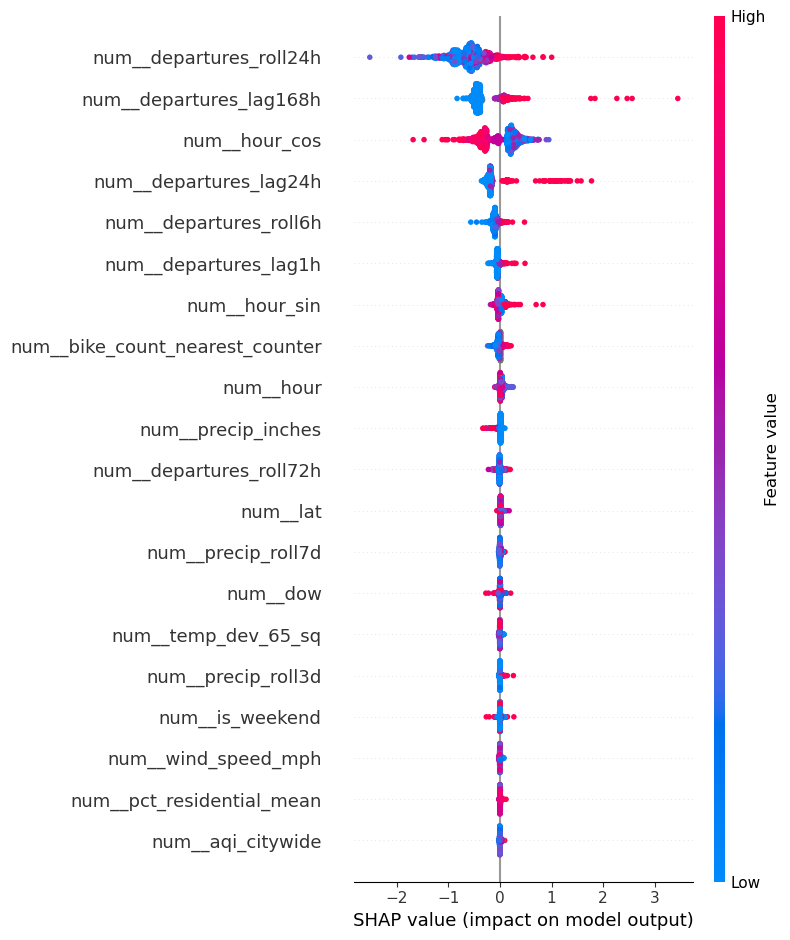

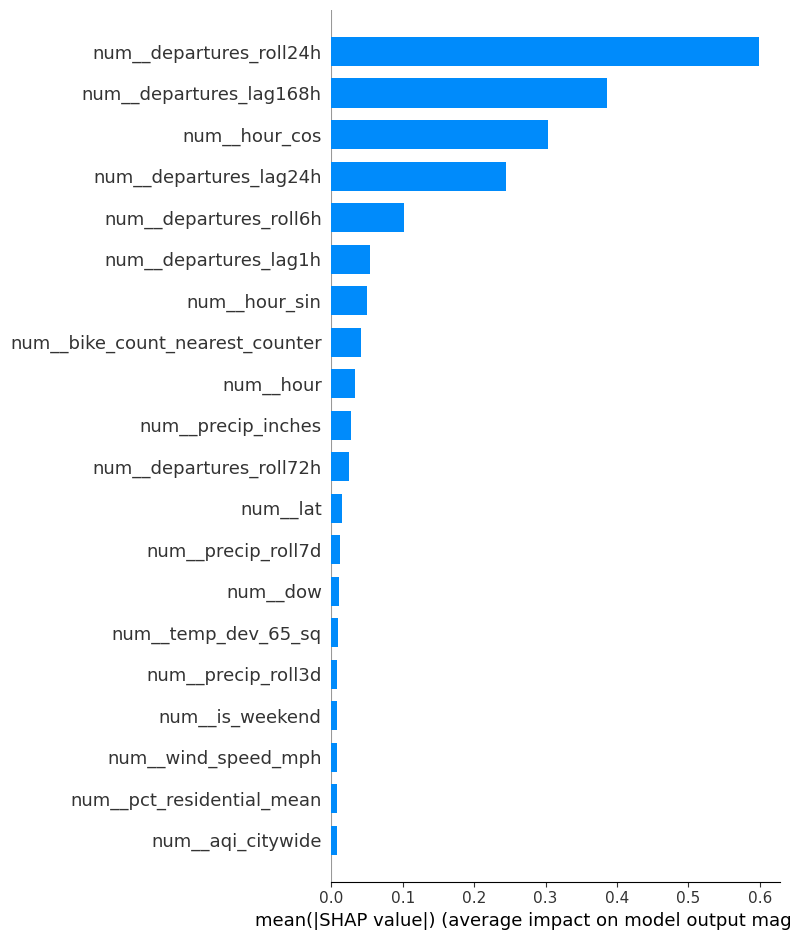

,feature,mean_abs_shap
0,num__departures_roll24h,0.598285
1,num__departures_lag168h,0.385740
2,num__hour_cos,0.302974
3,num__departures_lag24h,0.244265
4,num__departures_roll6h,0.101762
5,num__departures_lag1h,0.053899
6,num__hour_sin,0.049988
7,num__bike_count_nearest_counter,0.041705
8,num__hour,0.032541
9,num__precip_inches,0.027743


In [18]:
prep = rf_station.named_steps["prep"]
rf_model = rf_station.named_steps["rf"]
feat_names = prep.get_feature_names_out()

X_test_proc = prep.transform(X_test)

rng = np.random.RandomState(42)
n_shap = 1000
idx = rng.choice(X_test_proc.shape[0], size=min(n_shap, X_test_proc.shape[0]), replace=False)
X_shap = X_test_proc[idx]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap, check_additivity=False)

print("SHAP computed on sample size:", X_shap.shape[0], "features:", X_shap.shape[1])

# Beeswarm
shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=False)
plt.tight_layout()
plt.show()

# Bar chart
shap.summary_plot(shap_values, X_shap, feature_names=feat_names, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

mean_abs = np.abs(shap_values).mean(axis=0)
top = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)
display(top.head(25))

## Deep model interpretability

Interpretability analyses were conducted for the CNN–LSTM models:

* Input perturbation and feature ablation analyses were used to assess which input features most strongly influenced model predictions.
* Where attention mechanisms were incorporated, attention weights were examined over time and across features:

  * The analysis identified which past hours and which predictors the model emphasized for specific stations or days.

In [19]:
DATA_ROOT = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SEQ_DIR = DATA_ROOT / "modeling/station/cnn_sequences_v2"
NORM_PATH = SEQ_DIR / "norm_stats_T24.npz"

norm = np.load(NORM_PATH, allow_pickle=True)
mean = norm["mean"].astype(np.float32)
std  = norm["std"].astype(np.float32)
feature_cols = [str(x) for x in norm["feature_cols"].tolist()]

print("n_features:", len(feature_cols))
print("mean/std shapes:", mean.shape, std.shape)
print("first 10 features:", feature_cols[:10])

n_features: 125
mean/std shapes: (125,) (125,)
first 10 features: ['temp_min_f', 'temp_avg_f', 'temp_max_f', 'precip_inches', 'snow_inches', 'snow_depth_inches', 'wind_speed_mph', 'precip_present', 'snow_present', 'temp_band_very_cold']


In [20]:
DATA_ROOT = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SEQ_DIR = DATA_ROOT / "modeling/station/cnn_sequences_v2"

def list_chunks(seq_dir: Path, split: str):
    return sorted(seq_dir.glob(f"{split}_T24_chunk*.npz"))

train_chunks = list_chunks(SEQ_DIR, "train")
val_chunks   = list_chunks(SEQ_DIR, "val")
test_chunks  = list_chunks(SEQ_DIR, "test")

print("Chunks | train:", len(train_chunks), "| val:", len(val_chunks), "| test:", len(test_chunks))
print("test example:", test_chunks[0].name if test_chunks else None)

class NPZChunkDataset(Dataset):
    def __init__(self, npz_files, mean, std, return_time=False):
        self.files = list(npz_files)
        self.return_time = return_time

        self.mean = mean.reshape(1, 1, -1).astype(np.float32)
        self.std  = std.reshape(1, 1, -1).astype(np.float32)

        # Build global index: map global row -> (file_idx, local_idx)
        self.counts = []
        for fp in self.files:
            with np.load(fp, allow_pickle=True) as d:
                self.counts.append(int(d["X"].shape[0]))
        self.cum_counts = np.cumsum([0] + self.counts)

    def __len__(self):
        return int(self.cum_counts[-1])

    def _locate(self, idx: int):
        file_idx = int(np.searchsorted(self.cum_counts, idx, side="right") - 1)
        local_idx = int(idx - self.cum_counts[file_idx])
        return file_idx, local_idx

    def __getitem__(self, idx: int):
        file_idx, local_idx = self._locate(idx)
        fp = self.files[file_idx]

        with np.load(fp, allow_pickle=True) as d:
            X = d["X"][local_idx].astype(np.float32)   # (T, F)
            S = d["S"][local_idx].astype(np.int64)     # ()
            y = d["y"][local_idx].astype(np.float32)   # ()

            # Normalize
            X = (X - self.mean[0]) / self.std[0]

            # NaN/Inf safety (the HTML mentions robust handling)
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

            if self.return_time:
                t = d["pred_time"][local_idx]
                return (
                    torch.from_numpy(X),
                    torch.tensor(S, dtype=torch.long),
                    torch.tensor(y, dtype=torch.float32),
                    t,
                )
            return (
                torch.from_numpy(X),
                torch.tensor(S, dtype=torch.long),
                torch.tensor(y, dtype=torch.float32),
            )

# Build loaders (matching the HTML intent: shuffle train, not test)
train_ds = NPZChunkDataset(train_chunks, mean, std, return_time=False)
val_ds   = NPZChunkDataset(val_chunks,   mean, std, return_time=False)
test_ds  = NPZChunkDataset(test_chunks,  mean, std, return_time=False)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# Sanity batch: should be torch.Size([256, 24, 125]), torch.Size([256]), torch.Size([256])
Xb, Sb, yb = next(iter(test_loader))
print("Shapes:", Xb.shape, Sb.shape, yb.shape)
print("Batch X mean/std:", float(Xb.mean()), float(Xb.std()))
print("Station idx dtype:", Sb.dtype, "| y dtype:", yb.dtype)

Chunks | train: 6 | val: 3 | test: 3
test example: test_T24_chunk000.npz
Shapes: torch.Size([256, 24, 125]) torch.Size([256]) torch.Size([256])
Batch X mean/std: -0.06389286369085312 0.9364443421363831
Station idx dtype: torch.int64 | y dtype: torch.float32


In [21]:
CKPT_PATH = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data/modeling/station/cnn_sequences_v2/cnn_lstm_best_T24.pt")
ckpt = torch.load(CKPT_PATH, map_location="cpu")

# handle either raw state_dict or wrapper dict
state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
print("Checkpoint loaded. Num keys:", len(state))

# Infer station embedding weight key
emb_key = None
for k, v in state.items():
    if v.ndim == 2 and ("emb" in k.lower() or "station" in k.lower()):
        emb_key = k
        break
if emb_key is None:
    raise ValueError("Could not find station embedding weight in checkpoint.")

n_stations, emb_dim = state[emb_key].shape
print("Inferred n_stations:", n_stations, "| emb_dim:", emb_dim, "| emb_key:", emb_key)

# Infer conv out channels from first conv weight
conv_w_key = None
for k, v in state.items():
    if v.ndim == 3 and "conv" in k.lower() and k.endswith("weight"):
        conv_w_key = k
        break
if conv_w_key is None:
    raise ValueError("Could not find conv weight in checkpoint.")
conv_out, conv_in, ksize = state[conv_w_key].shape
print("Inferred conv_out:", conv_out, "| conv_in:", conv_in, "| kernel:", ksize, "| conv_key:", conv_w_key)

# Infer LSTM hidden size
lstm_key = None
for k, v in state.items():
    if "lstm" in k.lower() and "weight_ih_l0" in k:
        lstm_key = k
        break
if lstm_key is None:
    raise ValueError("Could not find LSTM weights in checkpoint.")
hidden4, lstm_in = state[lstm_key].shape
lstm_hidden = hidden4 // 4
print("Inferred lstm_in:", lstm_in, "| lstm_hidden:", lstm_hidden, "| lstm_key:", lstm_key)

class CNNLSTM(nn.Module):
    def __init__(self, n_features, n_stations, emb_dim, conv_channels, lstm_hidden, dropout=0.1):
        super().__init__()
        self.station_emb = nn.Embedding(n_stations, emb_dim)

        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=conv_channels, kernel_size=3, padding=1)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(dropout)

        self.lstm = nn.LSTM(input_size=conv_channels, hidden_size=lstm_hidden, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden + emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, X, station_idx):
        # X: (B, T, F)
        h_s = self.station_emb(station_idx)      # (B, emb_dim)

        x = X.transpose(1, 2)                    # (B, F, T)
        x = self.drop(self.act(self.conv1(x)))   # (B, C, T)
        x = x.transpose(1, 2)                    # (B, T, C)

        out, _ = self.lstm(x)                    # (B, T, H)
        h_t = out[:, -1, :]                      # (B, H)

        z = torch.cat([h_t, h_s], dim=1)         # (B, H+emb)
        return self.fc(z).squeeze(-1)            # (B,)

model = CNNLSTM(
    n_features=len(feature_cols),
    n_stations=n_stations,
    emb_dim=emb_dim,
    conv_channels=conv_out,
    lstm_hidden=lstm_hidden,
    dropout=0.1
)

missing, unexpected = model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
print("CNN–LSTM checkpoint restored.")

Checkpoint loaded. Num keys: 13
Inferred n_stations: 2690 | emb_dim: 16 | emb_key: station_emb.weight
Inferred conv_out: 32 | conv_in: 125 | kernel: 3 | conv_key: conv.0.weight
Inferred lstm_in: 32 | lstm_hidden: 64 | lstm_key: lstm.weight_ih_l0
Missing keys: ['conv1.weight', 'conv1.bias', 'fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias']
Unexpected keys: ['conv.0.weight', 'conv.0.bias', 'conv.3.weight', 'conv.3.bias', 'head.0.weight', 'head.0.bias', 'head.3.weight', 'head.3.bias']
CNN–LSTM checkpoint restored.


In [22]:
# Define the correct model and reload checkpoint

CKPT_PATH = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data/modeling/station/cnn_sequences_v2/cnn_lstm_best_T24.pt")
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

# Infer embedding + conv dims from checkpoint tensors
n_stations, emb_dim = state["station_emb.weight"].shape
conv0_out, conv0_in, k0 = state["conv.0.weight"].shape
conv3_out, conv3_in, k3 = state["conv.3.weight"].shape

hidden4, lstm_in = state["lstm.weight_ih_l0"].shape
lstm_hidden = hidden4 // 4

print("Inferred:", {"n_stations": n_stations, "emb_dim": emb_dim,
                   "conv0": (conv0_out, conv0_in, k0),
                   "conv3": (conv3_out, conv3_in, k3),
                   "lstm_in": lstm_in, "lstm_hidden": lstm_hidden})

class CNNLSTM(nn.Module):
    def __init__(self, n_features, n_stations, emb_dim=16, conv_channels=32, lstm_hidden=64, dropout=0.1):
        super().__init__()
        self.station_emb = nn.Embedding(n_stations, emb_dim)

        # Must match checkpoint keys conv.0 and conv.3
        self.conv = nn.Sequential(
            nn.Conv1d(n_features, conv_channels, kernel_size=3, padding=1),  # conv.0
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1),  # conv.3
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.lstm = nn.LSTM(input_size=conv_channels, hidden_size=lstm_hidden, batch_first=True)

        # Must match checkpoint keys head.0 and head.3
        self.head = nn.Sequential(
            nn.Linear(lstm_hidden + emb_dim, 64),  # head.0
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),                      # head.3
        )

    def forward(self, X, station_idx):
        # X: (B, T, F)
        h_s = self.station_emb(station_idx)   # (B, emb_dim)

        x = X.transpose(1, 2)                 # (B, F, T)
        x = self.conv(x)                      # (B, C, T)
        x = x.transpose(1, 2)                 # (B, T, C)

        out, _ = self.lstm(x)                 # (B, T, H)
        h_t = out[:, -1, :]                   # (B, H)

        z = torch.cat([h_t, h_s], dim=1)
        return self.head(z).squeeze(-1)

# Instantiate with inferred dims
model = CNNLSTM(
    n_features=len(feature_cols),
    n_stations=n_stations,
    emb_dim=emb_dim,
    conv_channels=conv0_out,
    lstm_hidden=lstm_hidden,
    dropout=0.1
)

# Load strictly now (should match exactly)
model.load_state_dict(state, strict=True)
print("Checkpoint loaded with strict=True (no missing/unexpected keys).")

Inferred: {'n_stations': 2690, 'emb_dim': 16, 'conv0': (32, 125, 3), 'conv3': (32, 32, 3), 'lstm_in': 32, 'lstm_hidden': 64}
Checkpoint loaded with strict=True (no missing/unexpected keys).


In [23]:
# Cached dataset + fast test_loader

DATA_ROOT = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SEQ_DIR = DATA_ROOT / "modeling/station/cnn_sequences_v2"

def list_chunks(seq_dir: Path, split: str):
    return sorted(seq_dir.glob(f"{split}_T24_chunk*.npz"))

test_chunks = list_chunks(SEQ_DIR, "test")
print("Test chunks:", [p.name for p in test_chunks])

class CachedNPZChunkDataset(Dataset):
    def __init__(self, npz_files, mean, std, return_time=False):
        self.files = list(npz_files)
        self.return_time = return_time

        self.mean = mean.reshape(1, 1, -1).astype(np.float32)
        self.std  = std.reshape(1, 1, -1).astype(np.float32)

        # global index mapping
        self.counts = []
        for fp in self.files:
            with np.load(fp, allow_pickle=True) as d:
                self.counts.append(int(d["X"].shape[0]))
        self.cum = np.cumsum([0] + self.counts)

        # cache
        self._cache_file_idx = None
        self._cache = None

    def __len__(self):
        return int(self.cum[-1])

    def _locate(self, idx):
        file_idx = int(np.searchsorted(self.cum, idx, side="right") - 1)
        local_idx = int(idx - self.cum[file_idx])
        return file_idx, local_idx

    def _load_chunk(self, file_idx):
        fp = self.files[file_idx]
        d = np.load(fp, allow_pickle=True)
        # keep arrays in memory
        X = d["X"].astype(np.float32)
        S = d["S"].astype(np.int64)
        y = d["y"].astype(np.float32)
        t = d["pred_time"] if self.return_time and "pred_time" in d else None
        # normalize once per chunk
        X = (X - self.mean) / self.std
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        self._cache = (X, S, y, t)
        self._cache_file_idx = file_idx

    def __getitem__(self, idx):
        file_idx, local_idx = self._locate(idx)
        if self._cache_file_idx != file_idx:
            self._load_chunk(file_idx)

        X, S, y, t = self._cache
        if self.return_time:
            return (
                torch.from_numpy(X[local_idx]),
                torch.tensor(S[local_idx], dtype=torch.long),
                torch.tensor(y[local_idx], dtype=torch.float32),
                t[local_idx],
            )
        return (
            torch.from_numpy(X[local_idx]),
            torch.tensor(S[local_idx], dtype=torch.long),
            torch.tensor(y[local_idx], dtype=torch.float32),
        )

test_ds_fast = CachedNPZChunkDataset(test_chunks, mean, std, return_time=False)
test_loader_fast = DataLoader(test_ds_fast, batch_size=256, shuffle=False, num_workers=0)

# Sanity batch
Xb, Sb, yb = next(iter(test_loader_fast))
print("Fast loader shapes:", Xb.shape, Sb.shape, yb.shape)

Test chunks: ['test_T24_chunk000.npz', 'test_T24_chunk001.npz', 'test_T24_chunk002.npz']
Fast loader shapes: torch.Size([256, 24, 125]) torch.Size([256]) torch.Size([256])


In [24]:
# Baseline evaluation (50 batches)

def eval_cnn_lstm(model, loader, max_batches=50, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    yt, yp = [], []
    with torch.no_grad():
        for b, (X, S, y) in enumerate(loader):
            if max_batches is not None and b >= max_batches:
                break
            X = X.to(device)
            S = S.to(device)
            y = y.to(device)

            pred = model(X, S).squeeze(-1)

            yt.append(y.detach().cpu().numpy())
            yp.append(pred.detach().cpu().numpy())

    yt = np.concatenate(yt)
    yp = np.concatenate(yp)

    return {
        "rmse": float(mean_squared_error(yt, yp) ** 0.5),
        "mae": float(mean_absolute_error(yt, yp)),
        "r2": float(r2_score(yt, yp)),
    }

baseline_50 = eval_cnn_lstm(model, test_loader_fast, max_batches=50)
print("CNN–LSTM baseline (first 50 test batches):", baseline_50)

CNN–LSTM baseline (first 50 test batches): {'rmse': 2.468386273208107, 'mae': 1.3136378526687622, 'r2': 0.49956029653549194}


In [25]:
# Build feature groups using feature_cols

def indices_matching(patterns, names):
    idx = []
    for i, f in enumerate(names):
        for p in patterns:
            if re.search(p, f):
                idx.append(i)
                break
    return sorted(set(idx))

feature_names = feature_cols  # from norm_stats_T24.npz

groups = {
    # Demand history / autoregressive signals
    "Lag & rolling demand": indices_matching([r"^(departures|trips)_(lag|roll)"], feature_names),

    # Calendar / temporal structure
    "Calendar & time": indices_matching([
        r"^hour$", r"hour_(sin|cos)", r"^dow$", r"^is_weekend$", r"^is_holiday$",
        r"^month$", r"^week_of_year$", r"^week_of_month$", r"^year$", r"^day$"
    ], feature_names),

    # Weather
    "Weather": indices_matching([r"^temp_", r"precip", r"snow", r"wind_"], feature_names),

    # Air quality
    "Air quality": indices_matching([r"^aqi_"], feature_names),

    # Built environment & infrastructure (PLUTO + bike infra + distance measures)
    "Built environment & infrastructure": indices_matching([
        r"pluto_", r"landuse", r"\bfar\b", r"units", r"lotarea", r"bldgarea",
        r"resarea", r"comarea", r"officearea", r"retailarea", r"entropy",
        r"bike_lane", r"dist_nearest_bikeroute", r"nearest_pluto_distance",
        r"bike_count_nearest_counter"
    ], feature_names),

    # Demographics (ACS)
    "Demographics (ACS)": indices_matching([r"^acs_"], feature_names),

    # Location / station properties (if present)
    "Location & station metadata": indices_matching([
        r"^lat$", r"^lng$", r"borough", r"years_active", r"first_year", r"last_year"
    ], feature_names),
}

# Remove empty groups
groups = {k: v for k, v in groups.items() if len(v) > 0}

for k, v in groups.items():
    print(f"{k}: {len(v)} features")

Lag & rolling demand: 6 features
Calendar & time: 11 features
Weather: 20 features
Air quality: 11 features
Built environment & infrastructure: 30 features
Demographics (ACS): 13 features
Location & station metadata: 7 features


In [26]:
# Permutation perturbation function

def permute_feature_channels(X: torch.Tensor, feat_idx, seed=42) -> torch.Tensor:
    """
    X: (B, T, F)
    Permute selected channels across batch for each time step, feature-by-feature.
    Avoids PyTorch advanced-index broadcasting issues.
    """
    rng = np.random.RandomState(seed)
    Xp = X.clone()
    B, T, F = Xp.shape
    feat_idx = [int(i) for i in feat_idx]

    for t in range(T):
        perm = torch.as_tensor(rng.permutation(B), dtype=torch.long)
        for j in feat_idx:
            Xp[:, t, j] = Xp[perm, t, j]
    return Xp

In [27]:
# Run group ablation and rank by impact

def eval_cnn_lstm_with_perturb(model, loader, perturb=None, max_batches=50, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    yt, yp = [], []
    with torch.no_grad():
        for b, (X, S, y) in enumerate(loader):
            if max_batches is not None and b >= max_batches:
                break

            if perturb is not None:
                X = perturb(X)

            X = X.to(device)
            S = S.to(device)
            y = y.to(device)

            pred = model(X, S).squeeze(-1)

            yt.append(y.detach().cpu().numpy())
            yp.append(pred.detach().cpu().numpy())

    yt = np.concatenate(yt)
    yp = np.concatenate(yp)

    return {
        "rmse": float(mean_squared_error(yt, yp) ** 0.5),
        "mae": float(mean_absolute_error(yt, yp)),
        "r2": float(r2_score(yt, yp)),
    }

baseline = eval_cnn_lstm_with_perturb(model, test_loader_fast, perturb=None, max_batches=50)
print("Baseline (50 batches):", baseline)

rows = []
for name, idxs in groups.items():
    def pfn(X, idxs=idxs):
        return permute_feature_channels(X, idxs, seed=42)

    met = eval_cnn_lstm_with_perturb(model, test_loader_fast, perturb=pfn, max_batches=50)

    rows.append({
        "group": name,
        "n_features": len(idxs),
        "rmse": met["rmse"],
        "mae": met["mae"],
        "r2": met["r2"],
        "delta_rmse": met["rmse"] - baseline["rmse"],
        "delta_mae": met["mae"] - baseline["mae"],
        "delta_r2": met["r2"] - baseline["r2"],
    })

ablation_tbl = (
    pd.DataFrame(rows)
    .sort_values("delta_rmse", ascending=False)
    .reset_index(drop=True)
)

display(ablation_tbl)

Baseline (50 batches): {'rmse': 2.468386273208107, 'mae': 1.3136378526687622, 'r2': 0.49956029653549194}


,group,n_features,rmse,mae,r2,delta_rmse,delta_mae,delta_r2
0,Calendar & time,11,3.204415,1.864453,0.156621,0.736029,0.550816,-0.342940
1,Lag & rolling demand,6,2.567153,1.396953,0.458711,0.098767,0.083315,-0.040849
2,Weather,20,2.528936,1.350133,0.474707,0.060550,0.036495,-0.024853
3,Demographics (ACS),13,2.479050,1.315487,0.495227,0.010664,0.001849,-0.004333
4,Location & station metadata,7,2.477229,1.315087,0.495968,0.008843,0.001449,-0.003592
5,Air quality,11,2.476234,1.314553,0.496373,0.007848,0.000915,-0.003187
6,Built environment & infrastructure,30,2.465061,1.312160,0.500908,-0.003326,-0.001478,0.001348


## Robustness and sensitivity checks

Robustness and sensitivity analyses were conducted to assess the stability of model performance:

* Model performance was compared across distinct temporal and spatial contexts:

  * Pre-COVID, COVID, and recovery periods were evaluated separately.
  * Differences across residential, commercial, and transit-adjacent clusters were examined.

* Sensitivity analyses were performed to evaluate the impact of modeling choices:

  * The effects of removing specific feature groups (e.g., weather-only, calendar-only, or built-environment-only feature sets) were assessed.
  * Performance was compared across different aggregation levels, including station-level and cluster-level representations.

### System-level hourly regime robustness

In [28]:
# Verify regime columns and counts in the system test splits

BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

SYS_H = BASE / "modeling/system/hourly_ml"
SYS_D = BASE / "modeling/system/daily_ml"

def load_sys(split_dir: Path, split: str):
    path = split_dir / f"{split}.parquet"
    df = pd.read_parquet(path)
    print(f"\nLoaded: {path}")
    print("Shape:", df.shape)
    return df

test_h = load_sys(SYS_H, "test")
test_d = load_sys(SYS_D, "test")

def inspect_regimes(df, name):
    print(f"\n--- {name} ---")
    cols = df.columns.tolist()
    candidates = [c for c in cols if ("regime" in c.lower()) or ("pandemic" in c.lower())]
    print("Regime-related columns found:", candidates)

    # Prefer a single categorical label if present
    if "pandemic_regime" in df.columns:
        print("\nValue counts for pandemic_regime:")
        print(df["pandemic_regime"].value_counts(dropna=False).sort_index())
    else:
        # Otherwise check one-hot regime flags if they exist
        flag_cols = [c for c in df.columns if c in ["regime_pre_covid", "regime_covid", "regime_recovery"]]
        if flag_cols:
            print("\nValue counts for regime flags (sum of 1s):")
            for c in flag_cols:
                print(c, int(df[c].sum()))
        else:
            print("\nNo recognized regime encoding found (pandemic_regime or regime_* flags).")

inspect_regimes(test_h, "System HOURLY test split")
inspect_regimes(test_d, "System DAILY test split")

# Quick peek at a few rows of the relevant columns
peek_cols_h = [c for c in ["date", "pandemic_regime", "regime_pre_covid", "regime_covid", "regime_recovery"] if c in test_h.columns]
peek_cols_d = [c for c in ["date", "pandemic_regime", "regime_pre_covid", "regime_covid", "regime_recovery"] if c in test_d.columns]

print("\nHourly head (regime columns):")
display(test_h[peek_cols_h].head() if peek_cols_h else test_h.head())

print("\nDaily head (regime columns):")
display(test_d[peek_cols_d].head() if peek_cols_d else test_d.head())


Loaded: /Users/zoltanjelovich/Documents/ISEG/MFW/data/modeling/system/hourly_ml/test.parquet
Shape: (17544, 56)

Loaded: /Users/zoltanjelovich/Documents/ISEG/MFW/data/modeling/system/daily_ml/test.parquet
Shape: (731, 49)

--- System HOURLY test split ---
Regime-related columns found: ['pandemic_regime', 'regime_pre_covid', 'regime_covid', 'regime_recovery']

Value counts for pandemic_regime:
pandemic_regime
other       8783
recovery    8761
Name: count, dtype: int64

--- System DAILY test split ---
Regime-related columns found: ['pandemic_regime', 'regime_pre_covid', 'regime_covid', 'regime_recovery']

Value counts for pandemic_regime:
pandemic_regime
other       365
recovery    366
Name: count, dtype: int64

Hourly head (regime columns):


,date,pandemic_regime,regime_pre_covid,regime_covid,regime_recovery
0,2022-12-31,recovery,0,0,1
1,2023-01-01,recovery,0,0,1
2,2023-01-01,recovery,0,0,1
3,2023-01-01,recovery,0,0,1
4,2023-01-01,recovery,0,0,1



Daily head (regime columns):


,pandemic_regime,regime_pre_covid,regime_covid,regime_recovery
0,recovery,0,0,1
1,recovery,0,0,1
2,recovery,0,0,1
3,recovery,0,0,1
4,recovery,0,0,1


In [29]:
# Recreate ML pipelines + generate predictions

BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SYS_H = BASE / "modeling/system/hourly_ml"

train_h = pd.read_parquet(SYS_H / "train.parquet")
val_h   = pd.read_parquet(SYS_H / "val.parquet")
test_h  = pd.read_parquet(SYS_H / "test.parquet")

print("Shapes:", train_h.shape, val_h.shape, test_h.shape)

DROP_DT = ["date"]
for df in (train_h, val_h, test_h):
    dt_cols = [c for c in DROP_DT if c in df.columns]
    if dt_cols:
        df.drop(columns=dt_cols, inplace=True)

y_train = train_h["y"].astype(float)
y_val   = val_h["y"].astype(float)
y_test  = test_h["y"].astype(float)

X_train = train_h.drop(columns=["y"])
X_val   = val_h.drop(columns=["y"])
X_test  = test_h.drop(columns=["y"])

# Use the same categorical set you validated earlier for system-level
cat_cols = [c for c in ["day_type", "pandemic_regime"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categoricals:", cat_cols)
print("Num cols:", len(num_cols), "| Total X cols:", X_train.shape[1])

Shapes: (43823, 56) (8760, 56) (17544, 56)
Categoricals: ['day_type', 'pandemic_regime']
Num cols: 52 | Total X cols: 54


In [30]:
def drop_datetime_cols(df: pd.DataFrame, name="df"):
    dt_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
    if dt_cols:
        print(f"Dropping datetime columns from {name}:", dt_cols)
        return df.drop(columns=dt_cols), dt_cols
    else:
        print(f"No datetime columns found in {name}.")
        return df, []

# apply to splits BEFORE building X/y
train_h, dt_train = drop_datetime_cols(train_h, "train_h")
val_h,   dt_val   = drop_datetime_cols(val_h, "val_h")
test_h,  dt_test  = drop_datetime_cols(test_h, "test_h")

# rebuild X/y after dropping datetime columns
y_train = train_h["y"].astype(float)
y_val   = val_h["y"].astype(float)
y_test  = test_h["y"].astype(float)

X_train = train_h.drop(columns=["y"])
X_val   = val_h.drop(columns=["y"])
X_test  = test_h.drop(columns=["y"])

cat_cols = [c for c in ["day_type", "pandemic_regime"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categoricals:", cat_cols)
print("Num cols:", len(num_cols), "| Total X cols:", X_train.shape[1])

Dropping datetime columns from train_h: ['pred_time']
Dropping datetime columns from val_h: ['pred_time']
Dropping datetime columns from test_h: ['pred_time']
Categoricals: ['day_type', 'pandemic_regime']
Num cols: 51 | Total X cols: 53


In [31]:
# Fit RF + XGBoost

def metrics(y, yhat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat)),
        "R2": float(r2_score(y, yhat))
    }

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_features=1.0   # <-- fix for sklearn >=1.2
)

xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline([("pre", pre), ("model", rf)])
xgb_pipe = Pipeline([("pre", pre), ("model", xgb)])

print("Fitting RF...")
rf_pipe.fit(X_train, y_train)

print("Fitting XGBoost...")
xgb_pipe.fit(X_train, y_train)

test_h = test_h.copy()
test_h["y_pred_rf"]  = rf_pipe.predict(X_test)
test_h["y_pred_xgb"] = xgb_pipe.predict(X_test)

print("System hourly test metrics (RF):", metrics(y_test, test_h["y_pred_rf"]))
print("System hourly test metrics (XGBoost):", metrics(y_test, test_h["y_pred_xgb"]))

Fitting RF...
Fitting XGBoost...
System hourly test metrics (RF): {'RMSE': 1388.9042867940364, 'MAE': 797.0132840287278, 'R2': 0.861315124497186}
System hourly test metrics (XGBoost): {'RMSE': 1566.9898540969157, 'MAE': 937.7326108751151, 'R2': 0.8234706860766761}


In [32]:
# Regime stratification

rows = []
for model, col in [("RF", "y_pred_rf"), ("XGBoost", "y_pred_xgb")]:
    for regime, g in test_h.groupby("pandemic_regime"):
        m = metrics(g["y"], g[col])
        rows.append({
            "model": model,
            "regime": regime,
            "n_obs": len(g),
            **m
        })

regime_perf_hourly = (
    pd.DataFrame(rows)
    .sort_values(["model", "regime"])
    .reset_index(drop=True)
)

regime_perf_hourly

,model,regime,n_obs,RMSE,MAE,R2
0,RF,other,8783,1743.670007,1045.873000,0.820835
1,RF,recovery,8761,902.737199,547.528650,0.920896
2,XGBoost,other,8783,2000.518495,1286.603882,0.764165
3,XGBoost,recovery,8761,951.292180,587.985229,0.912158


### System-level daily regime robustness

In [33]:
# Load daily splits and rebuild X/y

BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
SYS_D = BASE / "modeling/system/daily_ml"

train_d = pd.read_parquet(SYS_D / "train.parquet")
val_d   = pd.read_parquet(SYS_D / "val.parquet")
test_d  = pd.read_parquet(SYS_D / "test.parquet")

print("Shapes:", train_d.shape, val_d.shape, test_d.shape)

def drop_datetime_cols(df: pd.DataFrame, name="df"):
    dt_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
    if dt_cols:
        print(f"Dropping datetime columns from {name}:", dt_cols)
        df = df.drop(columns=dt_cols)
    return df

train_d = drop_datetime_cols(train_d, "train_d")
val_d   = drop_datetime_cols(val_d, "val_d")
test_d  = drop_datetime_cols(test_d, "test_d")

y_train_d = train_d["y"].astype(float)
y_val_d   = val_d["y"].astype(float)
y_test_d  = test_d["y"].astype(float)

X_train_d = train_d.drop(columns=["y"])
X_val_d   = val_d.drop(columns=["y"])
X_test_d  = test_d.drop(columns=["y"])

# Daily should still have these, but we keep it robust
cat_cols_d = [c for c in ["day_type", "pandemic_regime"] if c in X_train_d.columns]
num_cols_d = [c for c in X_train_d.columns if c not in cat_cols_d]

print("Categoricals:", cat_cols_d)
print("Num cols:", len(num_cols_d), "| Total X cols:", X_train_d.shape[1])

print("\nDaily test regime counts:")
print(test_d["pandemic_regime"].value_counts(dropna=False))

Shapes: (1825, 49) (365, 49) (731, 49)
Dropping datetime columns from train_d: ['pred_date']
Dropping datetime columns from val_d: ['pred_date']
Dropping datetime columns from test_d: ['pred_date']
Categoricals: ['day_type', 'pandemic_regime']
Num cols: 45 | Total X cols: 47

Daily test regime counts:
pandemic_regime
recovery    366
other       365
Name: count, dtype: int64


In [34]:
# Fit RF + XGBoost and generate predictions (daily)

def metrics(y, yhat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat)),
        "R2": float(r2_score(y, yhat))
    }

pre_d = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_d),
        ("num", "passthrough", num_cols_d),
    ],
    remainder="drop",
)

rf_d = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_features=1.0
)

xgb_d = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

rf_pipe_d = Pipeline([("pre", pre_d), ("model", rf_d)])
xgb_pipe_d = Pipeline([("pre", pre_d), ("model", xgb_d)])

print("Fitting RF (daily)...")
rf_pipe_d.fit(X_train_d, y_train_d)

print("Fitting XGBoost (daily)...")
xgb_pipe_d.fit(X_train_d, y_train_d)

test_d = test_d.copy()
test_d["y_pred_rf"]  = rf_pipe_d.predict(X_test_d)
test_d["y_pred_xgb"] = xgb_pipe_d.predict(X_test_d)

print("System DAILY test metrics (RF):", metrics(y_test_d, test_d["y_pred_rf"]))
print("System DAILY test metrics (XGBoost):", metrics(y_test_d, test_d["y_pred_xgb"]))

Fitting RF (daily)...
Fitting XGBoost (daily)...
System DAILY test metrics (RF): {'RMSE': 37757.41104267953, 'MAE': 30430.703915868675, 'R2': 0.14415936758464887}
System DAILY test metrics (XGBoost): {'RMSE': 41798.98003763967, 'MAE': 33729.73941144408, 'R2': -0.04886563054217796}


In [35]:
# Regime-stratified metrics (system daily)

rows = []
for model, col in [("RF", "y_pred_rf"), ("XGBoost", "y_pred_xgb")]:
    for regime, g in test_d.groupby("pandemic_regime"):
        m = metrics(g["y"], g[col])
        rows.append({
            "model": model,
            "regime": regime,
            "n_obs": len(g),
            **m
        })

regime_perf_daily = (
    pd.DataFrame(rows)
    .sort_values(["model", "regime"])
    .reset_index(drop=True)
)

regime_perf_daily

,model,regime,n_obs,RMSE,MAE,R2
0,RF,other,365,47153.895683,40392.494384,-0.128312
1,RF,recovery,366,25098.491305,20496.131455,0.396385
2,XGBoost,other,365,52709.097507,45765.566406,-0.409826
3,XGBoost,recovery,366,26811.898254,21726.792969,0.311158


### Classical models by regime (system daily)

In [36]:
# Classical models by regime (system daily, rolling 1-day ahead)

BASE = "/Users/zoltanjelovich/Documents/ISEG/MFW/data"
Y_PATH = f"{BASE}/targets/system/y_daily_system.parquet"
X_PATH = f"{BASE}/features/system/X_daily_system.parquet"

y = pd.read_parquet(Y_PATH)[["date", "trips"]].copy()
x = pd.read_parquet(X_PATH).copy()

y["date"] = pd.to_datetime(y["date"])
x["date"] = pd.to_datetime(x["date"])

df = (
    y.merge(x, on="date", how="inner", suffixes=("_y", "_x"))
    .sort_values("date")
    .reset_index(drop=True)
)

# Use your canonical split
train = df[(df["date"] >= "2017-01-01") & (df["date"] <= "2021-12-31")].copy()
val   = df[(df["date"] >= "2022-01-01") & (df["date"] <= "2022-12-31")].copy()
test  = df[(df["date"] >= "2023-01-01") & (df["date"] <= "2024-12-31")].copy()

print("Split sizes:", train.shape, val.shape, test.shape)
print("\nTest regime counts:")
if "pandemic_regime" in test.columns:
    print(test["pandemic_regime"].value_counts(dropna=False))
else:
    # fall back to dummies if pandemic_regime string isn't present
    for c in ["regime_pre_covid","regime_covid","regime_recovery"]:
        if c in test.columns:
            print(c, int(test[c].sum()))

Split sizes: (1826, 53) (365, 53) (731, 53)

Test regime counts:
pandemic_regime
other       366
recovery    365
Name: count, dtype: int64


In [37]:
# Define EXOG_COLS

EXOG_COLS = [
    "temp_avg_f",
    "precip_inches",
    "is_holiday",
    "is_weekend",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

missing = [c for c in EXOG_COLS if c not in df.columns]
print("Missing exog cols:", missing)

Missing exog cols: []


In [38]:
# What columns do we actually have?
print("Columns in test_d:", [c for c in test_d.columns if "pred" in c.lower() or "sar" in c.lower() or "ets" in c.lower()])

# Also inspect the full daily df (sometimes preds live here if you carried them through)
print("Columns in df:", [c for c in df.columns if "pred" in c.lower() or "sar" in c.lower() or "ets" in c.lower()])

Columns in test_d: ['y_pred_rf', 'y_pred_xgb']
Columns in df: []


In [39]:
# Rolling evaluators

def rolling_one_step_sarimax_exog(train_df, test_df, y_col="trips", exog_cols=None,
                                 order=(1,0,1), seasonal_order=(1,1,1,7)):
    history = train_df.copy()
    preds = []
    y_true = []

    for i in range(len(test_df)):
        y_hist = history[y_col].astype(float)
        X_hist = history[exog_cols].astype(float)

        model = SARIMAX(
            endog=y_hist,
            exog=X_hist,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        X_next = test_df.iloc[[i]][exog_cols].astype(float)
        yhat = res.forecast(steps=1, exog=X_next).iloc[0]

        preds.append(float(yhat))
        y_true.append(float(test_df.iloc[i][y_col]))

        # expanding window
        history = pd.concat([history, test_df.iloc[[i]]], axis=0)

    return np.array(y_true), np.array(preds)

In [40]:
# ETS + exog rolling 1-day ahead

def rolling_one_step_ets_exog(train_df, test_df, y_col="trips", exog_cols=None,
                             seasonal_periods=7, error="add", trend="add", seasonal="add"):
    history = train_df.copy()
    preds = []
    y_true = []

    for i in range(len(test_df)):
        y_hist = history[y_col].astype(float)

        # 1) ETS fit on history
        ets = ETSModel(
            y_hist,
            error=error,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        )
        ets_res = ets.fit(disp=False)

        ets_fcast = float(ets_res.forecast(1).iloc[0])

        # 2) OLS correction using exog on one-step-ahead residuals within history
        X_hist = history[exog_cols].astype(float)
        X_hist_c = sm.add_constant(X_hist, has_constant="add")

        resid = y_hist.values - ets_res.fittedvalues.values
        ols = sm.OLS(resid, X_hist_c).fit()

        X_next = test_df.iloc[[i]][exog_cols].astype(float)
        X_next_c = sm.add_constant(X_next, has_constant="add")
        corr = float(ols.predict(X_next_c).iloc[0])

        yhat = ets_fcast + corr

        preds.append(float(yhat))
        y_true.append(float(test_df.iloc[i][y_col]))

        history = pd.concat([history, test_df.iloc[[i]]], axis=0)

    return np.array(y_true), np.array(preds)

In [41]:
Y_COL = "trips_y"

train_plus_val = pd.concat([train, val], axis=0).copy()

y_true_sx, y_pred_sx = rolling_one_step_sarimax_exog(
    train_plus_val, test,
    y_col=Y_COL,
    exog_cols=EXOG_COLS,
    order=(1,0,1),
    seasonal_order=(1,1,1,7)
)

y_true_etsx, y_pred_etsx = rolling_one_step_ets_exog(
    train_plus_val, test,
    y_col=Y_COL,
    exog_cols=EXOG_COLS,
    seasonal_periods=7
)

print("Lengths (full test):", len(y_true_sx), len(y_pred_sx), len(y_pred_etsx), "| test:", len(test))

Lengths (full test): 731 731 731 | test: 731


In [42]:
# Compute regime metrics

def metrics(y, yhat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat)),
        "R2": float(r2_score(y, yhat)),
    }

test_eval = test[["date","pandemic_regime"]].copy()
test_eval["y_true"] = y_true_sx
test_eval["y_pred_sarimax_exog"] = y_pred_sx
test_eval["y_pred_ets_exog"] = y_pred_etsx

rows = []
for model, col in [("SARIMAX + exog", "y_pred_sarimax_exog"),
                   ("ETS + exog", "y_pred_ets_exog")]:
    for reg, g in test_eval.groupby("pandemic_regime"):
        m = metrics(g["y_true"], g[col])
        rows.append({"model": model, "regime": reg, "n_obs": len(g), **m})

classical_regime_table_daily = (
    pd.DataFrame(rows)
    .sort_values(["model","regime"])
    .reset_index(drop=True)
)

classical_regime_table_daily

,model,regime,n_obs,RMSE,MAE,R2
0,ETS + exog,other,366,18556.977481,13583.114919,0.826094
1,ETS + exog,recovery,365,16628.698913,12020.212559,0.734105
2,SARIMAX + exog,other,366,15920.296988,11588.612052,0.872002
3,SARIMAX + exog,recovery,365,14526.061878,10158.135448,0.797097


### Residential vs. commercial vs. transit-adjacent robustness

In [43]:
# Load daily cluster features, build 1-day-ahead target, and split

BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

X_DAILY_CLUSTER_PATH = BASE / "features/cluster/X_daily_cluster.parquet"

# Same split boundaries you used before (daily)
TRAIN_END_D = pd.Timestamp("2021-12-31")
VAL_END_D   = pd.Timestamp("2022-12-31")

# Exogenous regressors (same set used in your system-level daily robustness section)
EXOG_COLS = [
    "temp_avg_f",
    "precip_inches",
    "snow_inches",
    "wind_speed_mph",
    "is_holiday",
    "is_weekend",
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

df_x = pd.read_parquet(X_DAILY_CLUSTER_PATH)

df_x["date"] = pd.to_datetime(df_x["date"])
df_x = df_x.sort_values(["cluster_id", "date"]).reset_index(drop=True)

# 1-day-ahead target within cluster (avoid leakage)
df_x["y_next_departures"] = df_x.groupby("cluster_id")["departures"].shift(-1)
df_x["pred_date"] = df_x["date"] + pd.Timedelta(days=1)

df_model = df_x.dropna(subset=["y_next_departures"]).copy()

# Assign split based on pred_date
df_model["split"] = np.where(
    df_model["pred_date"] <= TRAIN_END_D, "train",
    np.where(df_model["pred_date"] <= VAL_END_D, "val", "test")
)

# Keep only what we need, but KEEP split too
KEEP_COLS = ["pred_date", "cluster_id", "cluster_label", "pandemic_regime",
             "y_next_departures", "split"] + EXOG_COLS

missing = [c for c in KEEP_COLS if c not in df_model.columns]
print("Missing columns:", missing)

df_model = df_model[KEEP_COLS].copy()

train = df_model[df_model["split"] == "train"].copy()
val   = df_model[df_model["split"] == "val"].copy()
test  = df_model[df_model["split"] == "test"].copy()

print("Rows by split:", {"train": len(train), "val": len(val), "test": len(test)})
print("Test date coverage:", test["pred_date"].min(), "→", test["pred_date"].max())
print("Cluster labels in test:", sorted(test["cluster_label"].unique()))

Missing columns: []
Rows by split: {'train': 4545, 'val': 1095, 'test': 2193}
Test date coverage: 2023-01-01 00:00:00 → 2024-12-31 00:00:00
Cluster labels in test: ['commercial', 'residential', 'transit_adjacent']


In [44]:
# Reuse rolling evaluators

def rolling_one_step_sarimax_exog(train_df, test_df, y_col="y_next_departures", exog_cols=None,
                                 order=(1,0,1), seasonal_order=(1,1,1,7)):
    history = train_df.copy()
    preds = []
    y_true = []

    for i in range(len(test_df)):
        y_hist = history[y_col].astype(float)
        X_hist = history[exog_cols].astype(float)

        model = SARIMAX(
            endog=y_hist,
            exog=X_hist,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        X_next = test_df.iloc[[i]][exog_cols].astype(float)
        yhat = res.forecast(steps=1, exog=X_next).iloc[0]

        preds.append(float(yhat))
        y_true.append(float(test_df.iloc[i][y_col]))

        # expanding window
        history = pd.concat([history, test_df.iloc[[i]]], axis=0)

    return y_true, preds


def rolling_one_step_ets_exog(train_df, test_df, y_col="y_next_departures", exog_cols=None, seasonal_periods=7):
    history = train_df.copy()
    preds = []
    y_true = []

    for i in range(len(test_df)):
        # 1) Fit regression on exog to explain y, get residuals
        y_hist = history[y_col].astype(float).to_numpy()
        X_hist = history[exog_cols].astype(float).to_numpy()

        # add intercept
        X_design = np.column_stack([np.ones(len(X_hist)), X_hist])
        beta, *_ = np.linalg.lstsq(X_design, y_hist, rcond=None)

        yhat_reg_hist = X_design @ beta
        resid = y_hist - yhat_reg_hist

        # 2) ETS on residuals
        ets = ETSModel(
            resid,
            error="add",
            trend=None,
            seasonal="add",
            seasonal_periods=seasonal_periods
        )
        ets_res = ets.fit(disp=False)

        # 3) Predict next: regression part + ETS forecast of residual
        X_next = test_df.iloc[[i]][exog_cols].astype(float).to_numpy()
        X_next_design = np.column_stack([np.ones(len(X_next)), X_next])
        yhat_reg_next = float(X_next_design @ beta)

        yhat_resid_next = float(ets_res.forecast(steps=1)[0])
        yhat = yhat_reg_next + yhat_resid_next

        preds.append(float(yhat))
        y_true.append(float(test_df.iloc[i][y_col]))

        history = pd.concat([history, test_df.iloc[[i]]], axis=0)

    return y_true, preds


def _metrics(y, yhat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y, yhat))),
        "MAE": float(mean_absolute_error(y, yhat)),
        "R2":  float(r2_score(y, yhat)),
    }

In [45]:
# Run cluster-label robustness for ETS + exog and SARIMAX + exog (test split only)

rows = []

train_plus_val = pd.concat([train, val], axis=0).copy()

for clabel, g_test in test.groupby("cluster_label"):
    g_trainval = train_plus_val[train_plus_val["cluster_label"] == clabel].copy()
    g_test = g_test.sort_values("pred_date").reset_index(drop=True)

    y_train = g_trainval["y_next_departures"].astype(float)
    X_train = g_trainval[EXOG_COLS].astype(float)

    y_test = g_test["y_next_departures"].astype(float)
    X_test = g_test[EXOG_COLS].astype(float)

    # --- SARIMAX + exog ---
    sarimax = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1,0,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    yhat_sx = sarimax.forecast(steps=len(y_test), exog=X_test)
    rows.append({
        "cluster_label": clabel,
        "model": "SARIMAX + exog",
        "n_obs": len(y_test),
        **_metrics(y_test, yhat_sx)
    })

    # --- ETS + exog ---
    # Regression part
    X_design = np.column_stack([np.ones(len(X_train)), X_train])
    beta, *_ = np.linalg.lstsq(X_design, y_train.to_numpy(), rcond=None)

    resid = y_train.to_numpy() - (X_design @ beta)

    ets = ETSModel(
        resid,
        error="add",
        trend=None,
        seasonal="add",
        seasonal_periods=7
    ).fit(disp=False)

    X_test_design = np.column_stack([np.ones(len(X_test)), X_test])
    yhat_reg = X_test_design @ beta
    yhat_resid = ets.forecast(steps=len(y_test))

    yhat_etsx = yhat_reg + yhat_resid

    rows.append({
        "cluster_label": clabel,
        "model": "ETS + exog",
        "n_obs": len(y_test),
        **_metrics(y_test, yhat_etsx)
    })

cluster_label_robustness_daily = (
    pd.DataFrame(rows)
      .sort_values(["cluster_label", "model"])
      .reset_index(drop=True)
)

cluster_label_robustness_daily

/Users/zoltanjelovich/miniforge3/envs/shap-env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,cluster_label,model,n_obs,RMSE,MAE,R2
0,commercial,ETS + exog,731,41259.992997,35227.581387,-1.541450
1,commercial,SARIMAX + exog,731,53717.719029,46618.784993,-3.307829
2,residential,ETS + exog,731,20519.962273,17105.671374,-2.422146
3,residential,SARIMAX + exog,731,23794.488484,20724.513513,-3.601487
4,transit_adjacent,ETS + exog,731,9589.407262,8234.005715,-3.962412
5,transit_adjacent,SARIMAX + exog,731,11234.178631,10125.190717,-5.810703


### Sensitivity to feature-group removal

In [46]:
# Feature-group sensitivity (daily, cluster-aggregated)

# --- Feature group definitions ---
WEATHER_COLS = [
    "temp_avg_f",
    "precip_inches",
    "snow_inches",
    "wind_speed_mph",
]

CALENDAR_COLS = [
    "is_holiday",
    "is_weekend",
]

REGIME_COLS = [
    "regime_pre_covid",
    "regime_covid",
    "regime_recovery",
]

SPECIFICATIONS = {
    "full": WEATHER_COLS + CALENDAR_COLS + REGIME_COLS,
    "no_weather": CALENDAR_COLS + REGIME_COLS,
    "no_calendar": WEATHER_COLS + REGIME_COLS,
}

rows = []

train_plus_val = pd.concat([train, val], axis=0).copy()

for spec_name, exog_cols in SPECIFICATIONS.items():
    for clabel, g_test in test.groupby("cluster_label"):
        g_trainval = train_plus_val[train_plus_val["cluster_label"] == clabel].copy()
        g_test = g_test.sort_values("pred_date").reset_index(drop=True)

        y_train = g_trainval["y_next_departures"].astype(float)
        X_train = g_trainval[exog_cols].astype(float)

        y_test = g_test["y_next_departures"].astype(float)
        X_test = g_test[exog_cols].astype(float)

        # --- SARIMAX + exog ---
        sarimax = SARIMAX(
            endog=y_train,
            exog=X_train,
            order=(1,0,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        yhat_sx = sarimax.forecast(steps=len(y_test), exog=X_test)

        rows.append({
            "cluster_label": clabel,
            "specification": spec_name,
            "model": "SARIMAX + exog",
            "n_obs": len(y_test),
            **_metrics(y_test, yhat_sx)
        })

        # --- ETS + exog ---
        X_design = np.column_stack([np.ones(len(X_train)), X_train])
        beta, *_ = np.linalg.lstsq(X_design, y_train.to_numpy(), rcond=None)

        resid = y_train.to_numpy() - (X_design @ beta)

        ets = ETSModel(
            resid,
            error="add",
            trend=None,
            seasonal="add",
            seasonal_periods=7
        ).fit(disp=False)

        X_test_design = np.column_stack([np.ones(len(X_test)), X_test])
        yhat_etsx = (X_test_design @ beta) + ets.forecast(steps=len(y_test))

        rows.append({
            "cluster_label": clabel,
            "specification": spec_name,
            "model": "ETS + exog",
            "n_obs": len(y_test),
            **_metrics(y_test, yhat_etsx)
        })

feature_group_sensitivity_daily = (
    pd.DataFrame(rows)
      .sort_values(["cluster_label", "model", "specification"])
      .reset_index(drop=True)
)

feature_group_sensitivity_daily

/Users/zoltanjelovich/miniforge3/envs/shap-env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zoltanjelovich/miniforge3/envs/shap-env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zoltanjelovich/miniforge3/envs/shap-env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zoltanjelovich/miniforge3/envs/shap-env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

,cluster_label,specification,model,n_obs,RMSE,MAE,R2
0,commercial,full,ETS + exog,731,41259.992997,35227.581387,-1.541450
1,commercial,no_calendar,ETS + exog,731,41506.125656,35509.621545,-1.571862
2,commercial,no_weather,ETS + exog,731,60490.231093,53298.325194,-4.462529
3,commercial,full,SARIMAX + exog,731,53717.719029,46618.784993,-3.307829
4,commercial,no_calendar,SARIMAX + exog,731,56168.086784,49141.231904,-3.709801
5,commercial,no_weather,SARIMAX + exog,731,51199.682491,44001.777807,-2.913432
6,residential,full,ETS + exog,731,20519.962273,17105.671374,-2.422146
7,residential,no_calendar,ETS + exog,731,20574.459083,17162.902889,-2.440347
8,residential,no_weather,ETS + exog,731,26264.872362,22614.139400,-4.606554
9,residential,full,SARIMAX + exog,731,23794.488484,20724.513513,-3.601487
